In [1]:
import sys
sys.path.append('..')

from models.compression.vq_vae import VQVAE
from dataset import ImageCompressionDataModule

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

model = VQVAE(    h_dim=128,
    res_h_dim=128,
    n_res_layers=3,
    n_embeddings=512,
    embedding_dim=64,
    beta=0.25,
    device=device).to(device)

model = VQVAE.load_from_checkpoint("../../checkpoints/vq_vae_model_best.ckpt").to(device)


print(model)

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth
VQVAE(
  (encoder): Encoder(
    (initial): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (downsample1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=

In [3]:
from PIL import Image
import torch

import torchvision.transforms as transforms

img = Image.open("../../images/compress_test.png").convert("RGB")
transform = transforms.ToTensor()
img_tensor = transform(img)

In [4]:
out = model(img_tensor.unsqueeze(0).to(device))
_, reconstructed_img, _ = out
reconstructed_img = reconstructed_img.squeeze(0).cpu().detach()
reconstructed_img = ((reconstructed_img + 1) / 2 * 255).clamp(0, 255).int()

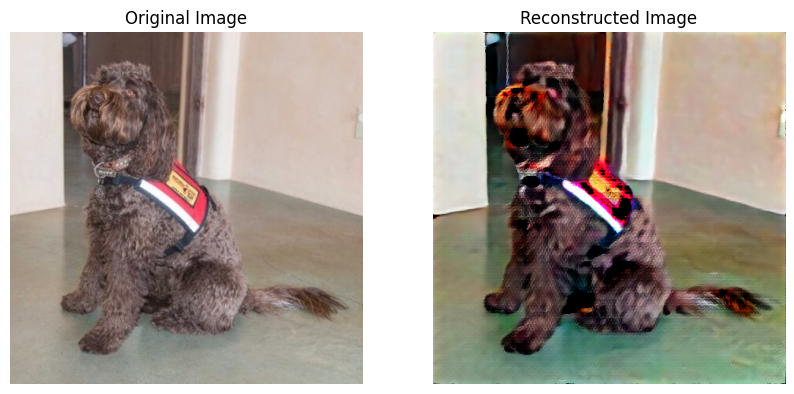

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(reconstructed_img.permute(1, 2, 0).numpy())
axs[1].set_title("Reconstructed Image")
axs[1].axis("off")

plt.show()

In [6]:
dataset = ImageCompressionDataModule(
    data_dir="../../data/PetImages",
    batch_size=1,
)

dataset=dataset.setup()

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]
Loading model from: /home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth


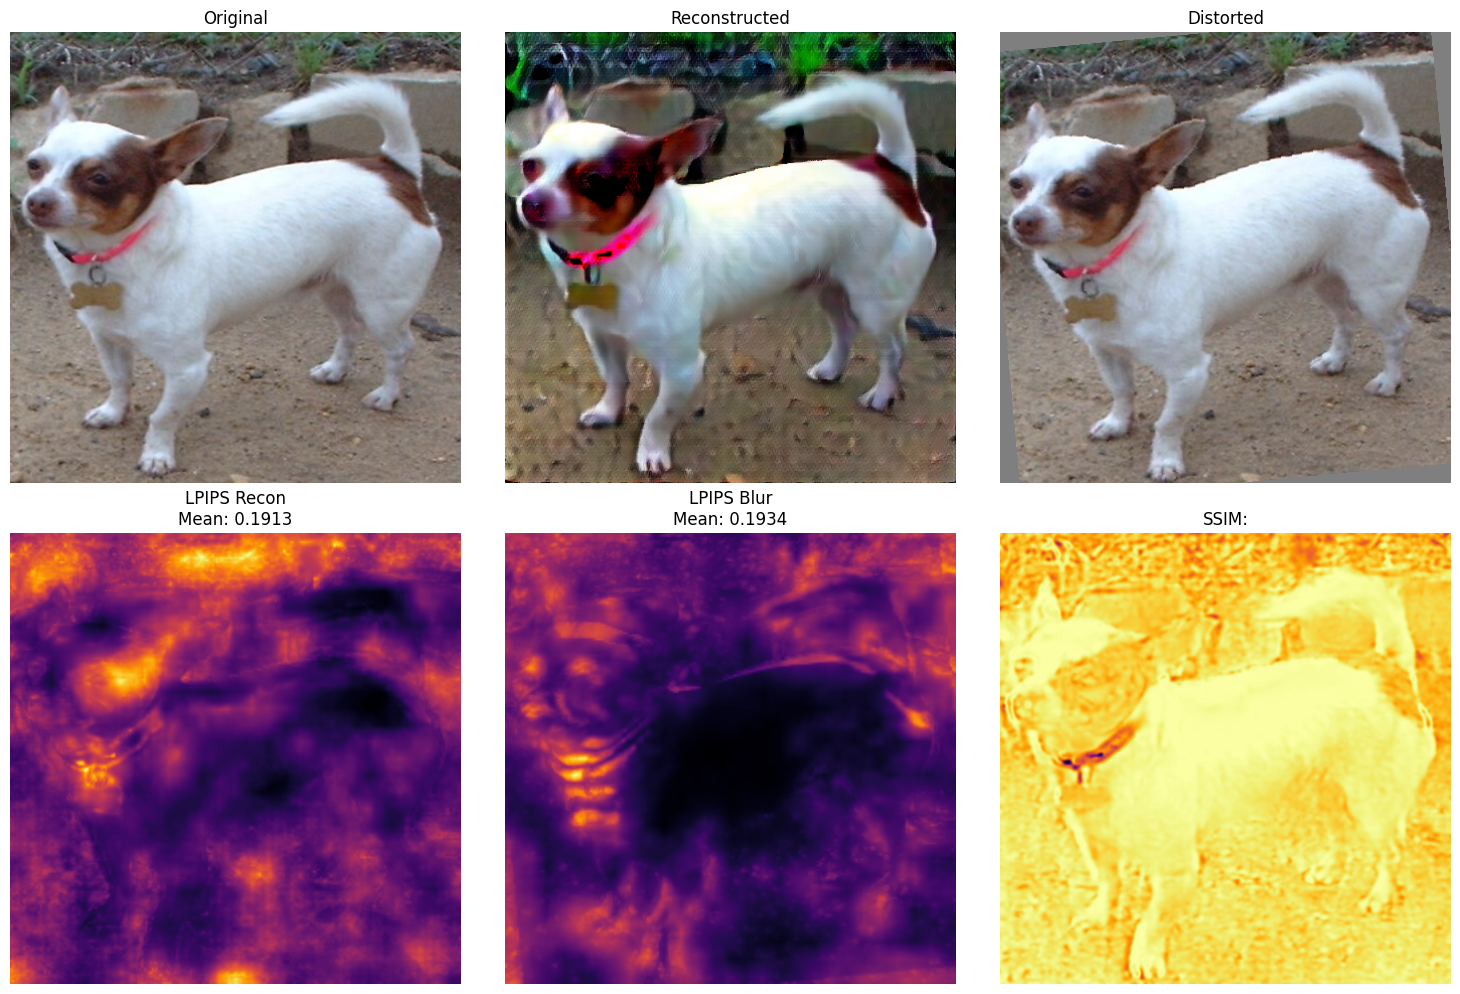

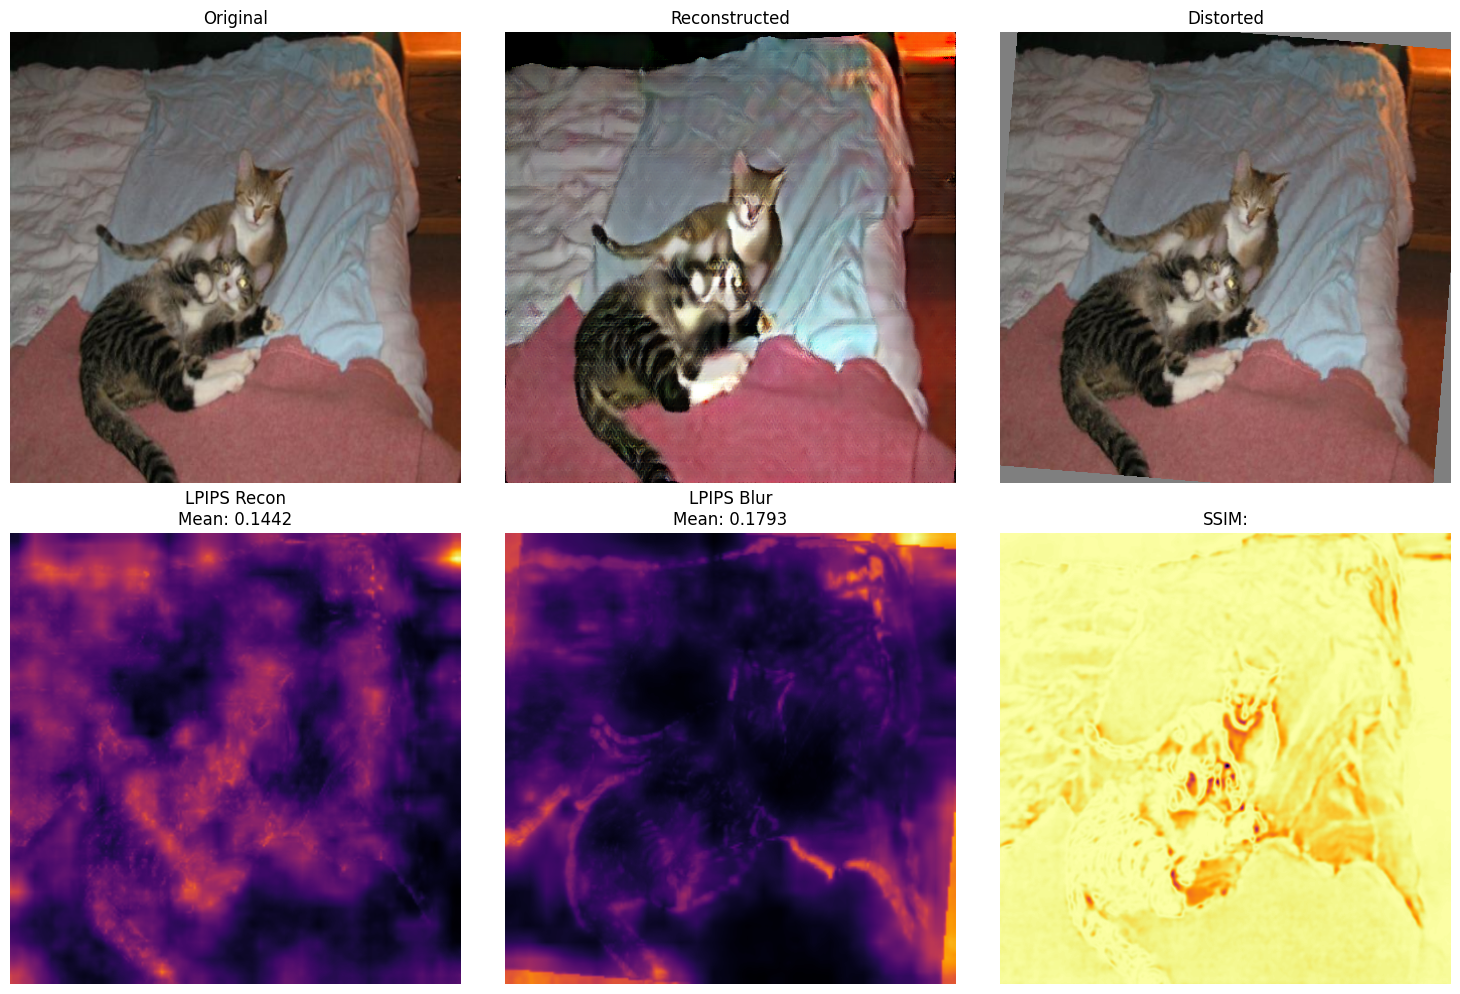

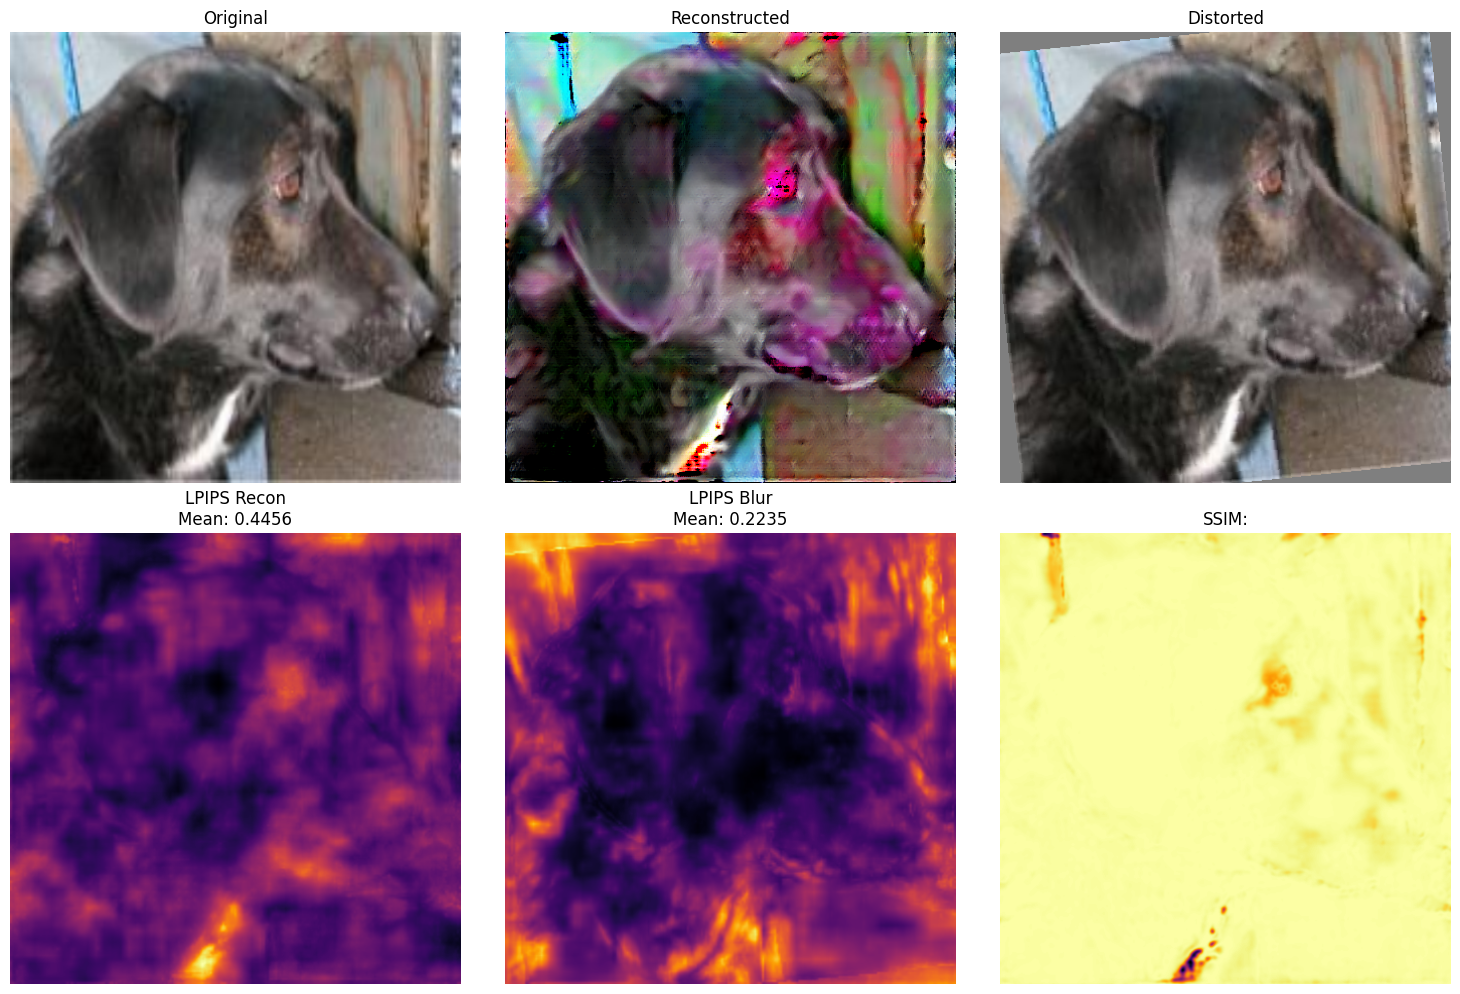

In [13]:
from lpips import LPIPS
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

lpips = LPIPS(net='squeeze', spatial=True).to(device)
transform = T.Compose([
    T.RandomRotation(10),
    
])

with torch.no_grad():
    for i in range(3):
        batch = dataset.val_dataloader().dataset[i]
        img_tensor = batch[0].unsqueeze(0).to(device)

        _, reconstructed_img, _ = model(img_tensor)
        reconstructed_img = reconstructed_img.clamp(-1, 1)

        distorted_img = transform(img_tensor)

        loss_map_recon = lpips(img_tensor, reconstructed_img).cpu().squeeze().numpy()
        loss_map_blur = lpips(img_tensor, distorted_img).cpu().squeeze().numpy()

        orig_np = ((img_tensor.squeeze().permute(1, 2, 0).cpu().numpy() + 1) / 2 * 255).astype("uint8")
        recon_np = ((reconstructed_img.squeeze().permute(1, 2, 0).cpu().numpy() + 1) / 2 * 255).astype("uint8")
        blur_np = ((distorted_img.squeeze().permute(1, 2, 0).cpu().numpy() + 1) / 2 * 255).astype("uint8")

        orig_tensor = torch.from_numpy(orig_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        recon_tensor = torch.from_numpy(recon_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0

        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        
        orig_tensor = torch.from_numpy(orig_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        recon_tensor = torch.from_numpy(recon_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        
        ssim_value_matrix = model.ssim_loss(orig_tensor, recon_tensor)

        axs[1, 2].imshow(ssim_value_matrix.squeeze().mean(0).cpu().numpy(), cmap="inferno")
        axs[1, 2].set_title(f"SSIM:")
        axs[1, 2].axis("off")

        axs[0, 0].imshow(orig_np)
        axs[0, 0].set_title("Original")
        axs[0, 0].axis("off")

        axs[0, 1].imshow(recon_np)
        axs[0, 1].set_title("Reconstructed")
        axs[0, 1].axis("off")

        axs[0, 2].imshow(blur_np)
        axs[0, 2].set_title("Distorted")
        axs[0, 2].axis("off")

        axs[1, 0].imshow(loss_map_recon, cmap="inferno")
        axs[1, 0].set_title(f"LPIPS Recon\nMean: {loss_map_recon.mean():.4f}")
        axs[1, 0].axis("off")

        axs[1, 1].imshow(loss_map_blur, cmap="inferno")
        axs[1, 1].set_title(f"LPIPS Blur\nMean: {loss_map_blur.mean():.4f}")
        axs[1, 1].axis("off")

        axs[1, 2].axis("off")

        plt.tight_layout()
        plt.show()
